In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy.ndimage as nd
import scipy

In [2]:
img = imread('/oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD589_lossless_aligned_cropped_grayscale/MD589_0134_lossless_aligned_cropped_grayscale.tif')

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/external/tifffile/tifffile_local.py:3246: UserWarning: unexpected end of lzw stream (code 0)
  warnings.warn("unexpected end of lzw stream (code %i)" % code)


In [3]:
im = img[7245:7245+208, 2845:2845+190]
# im = img[6972:6972+780, 3848:3848+1765]

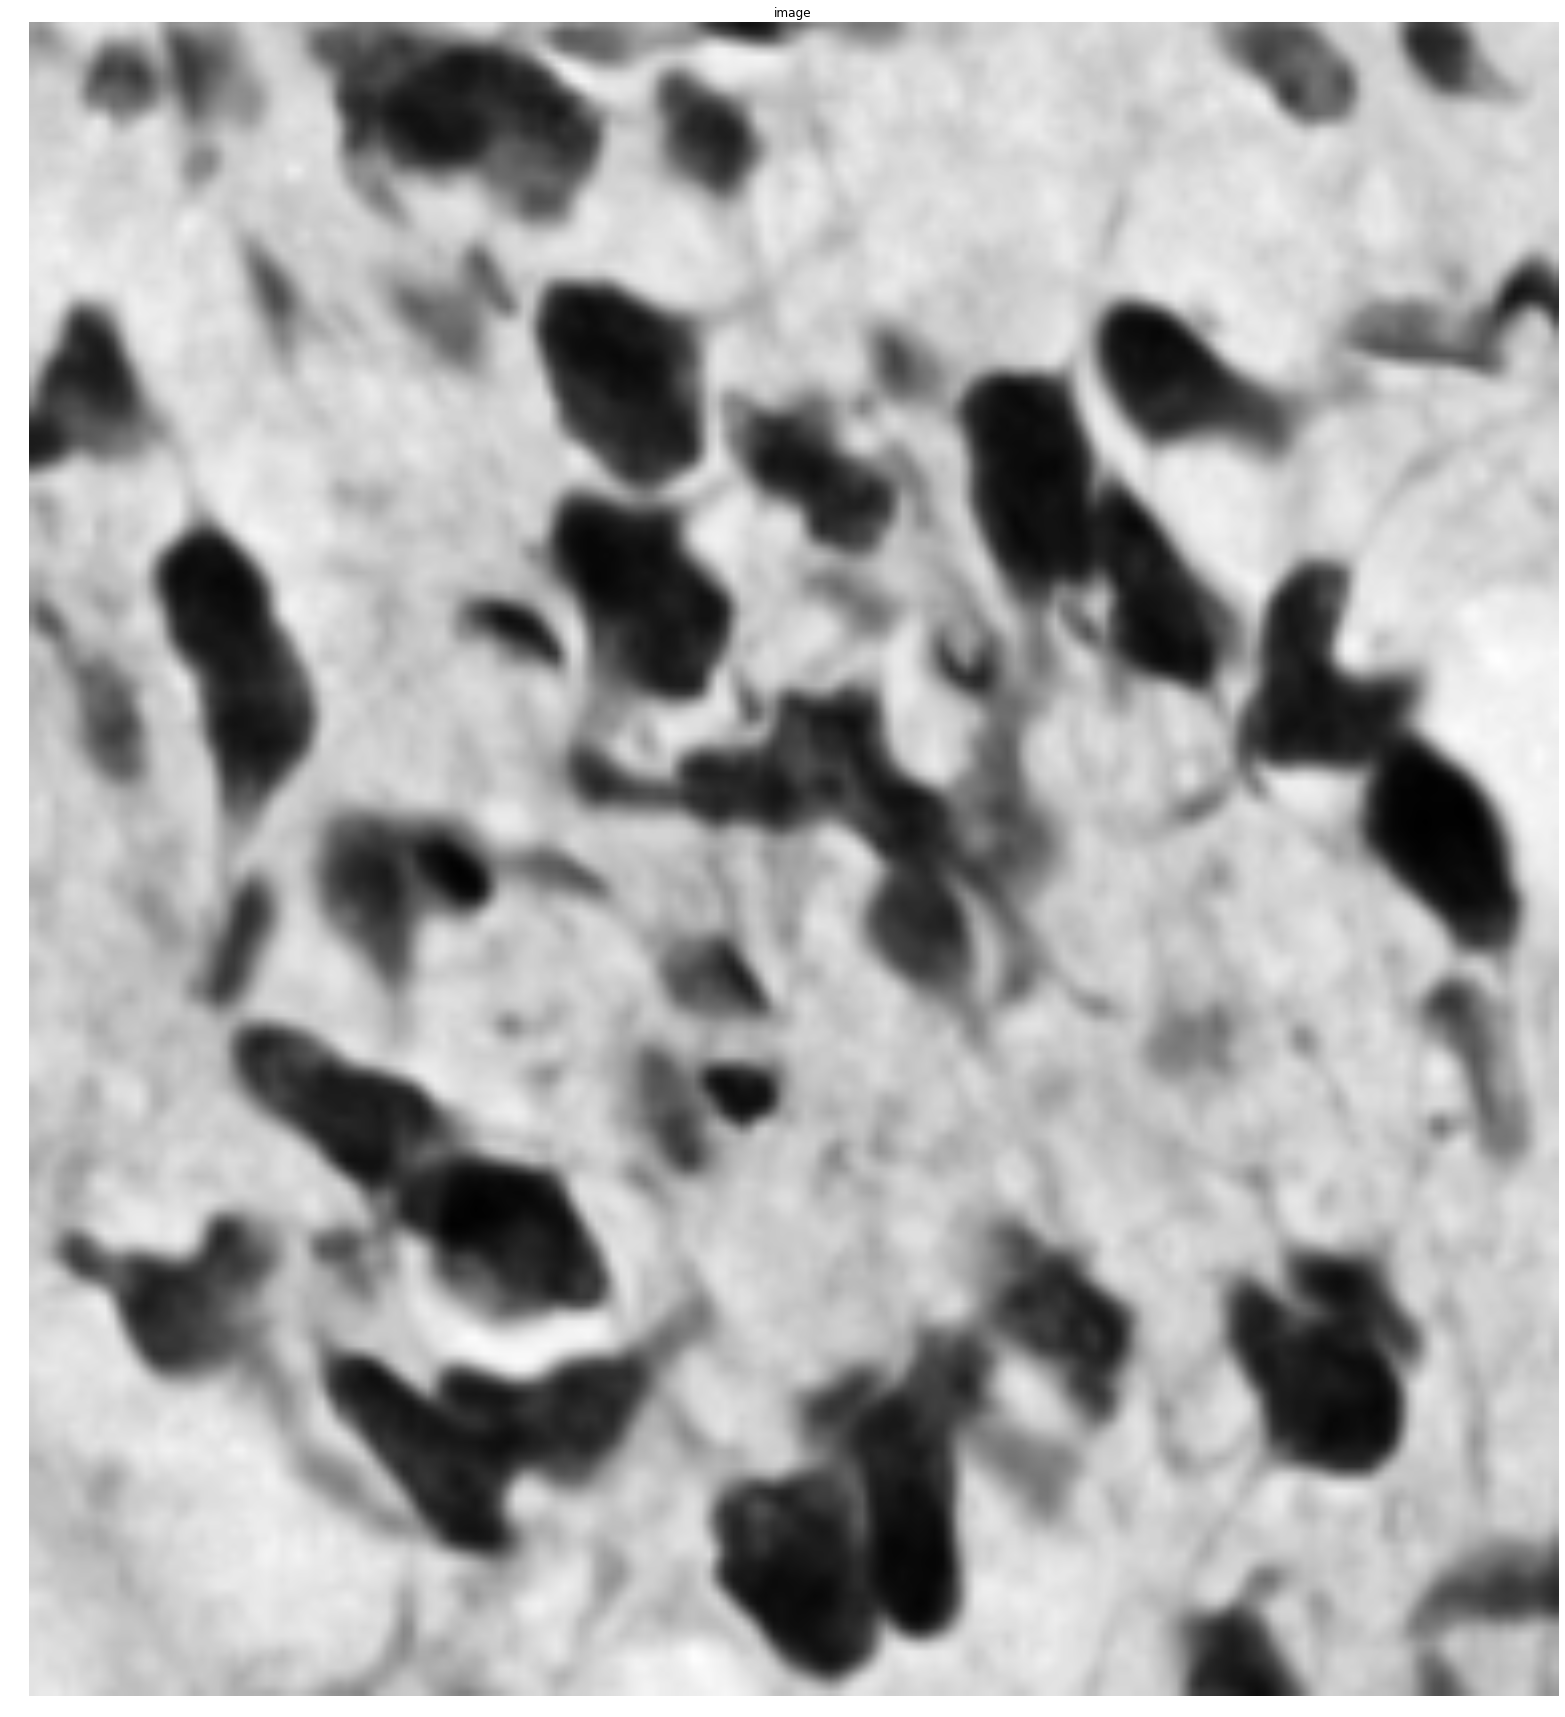

In [98]:
plt.figure(figsize=(30,30));
plt.imshow(im, cmap=plt.cm.gray);
plt.axis('off');
plt.title('image');

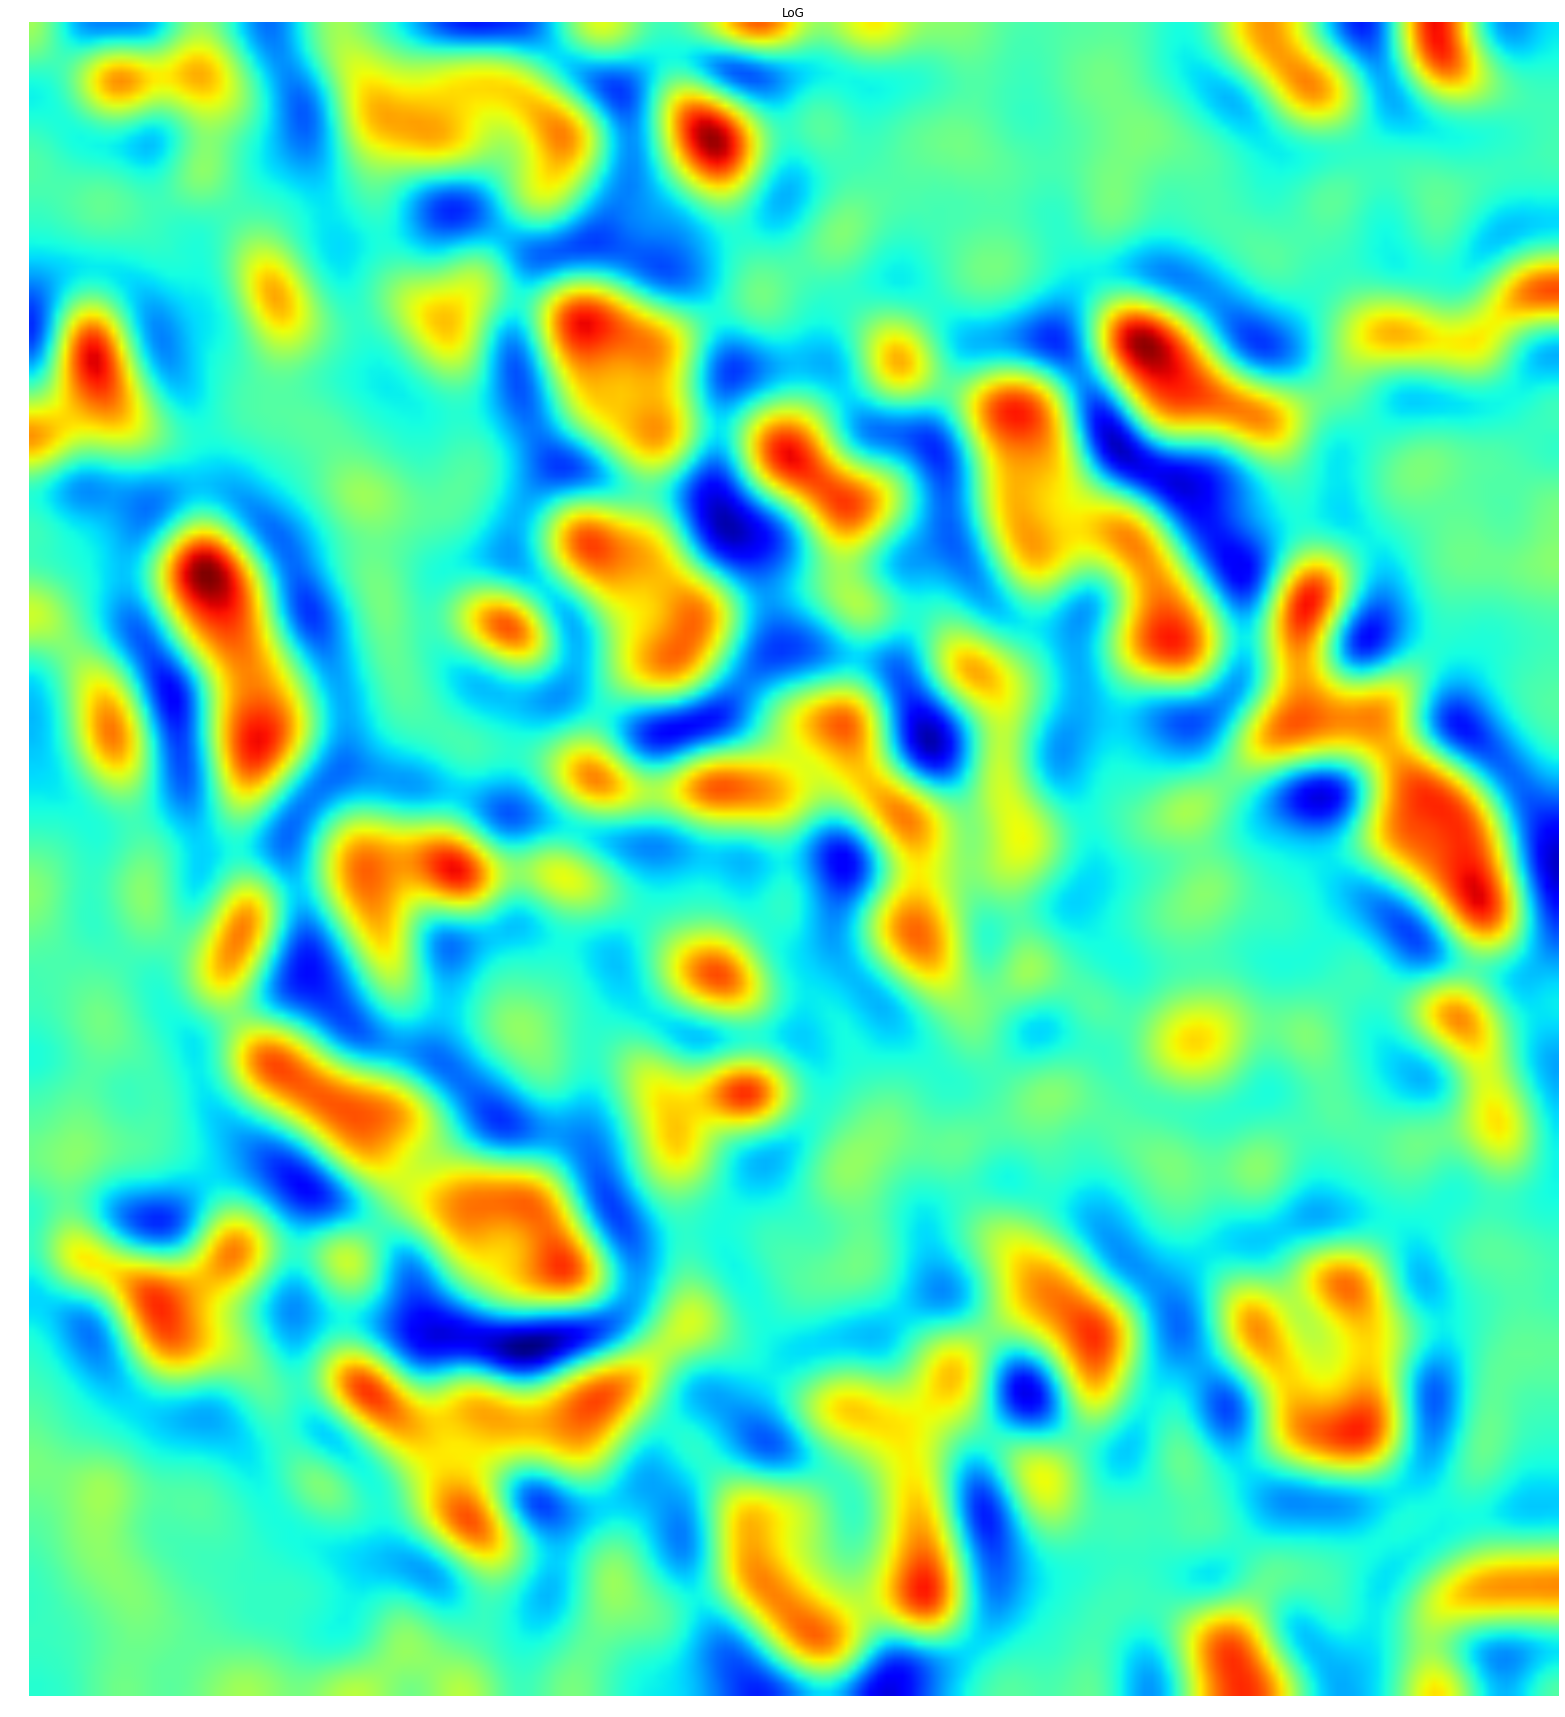

In [99]:
plt.figure(figsize=(30,30));

LoG = nd.gaussian_laplace(im.astype(np.float), 4)

plt.imshow(LoG);
plt.axis('off');
plt.title('LoG');
# plt.colorbar();

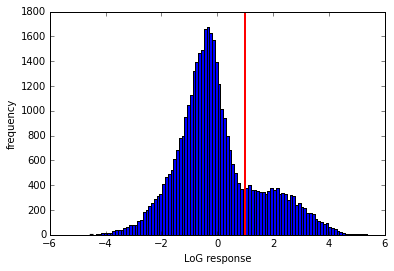

In [100]:
LoG_thres = 1.

plt.hist(LoG.flat, bins=100);
plt.gca().axvline(x=LoG_thres, c='r', linewidth=2);
plt.xlabel('LoG response');
plt.ylabel('frequency');

In [101]:
s3 = np.sign(LoG - LoG_thres)
s3[0,:] = 0
s3[-1,:] = 0
s3[:,0] = 0
s3[:,-1] = 0

s3[s3==0] = -1     # replace zeros with -1

diff_x = np.r_[np.zeros((1,im.shape[1]), np.bool), (np.diff(s3, axis=0) != 0)]
diff_y = np.c_[np.zeros((im.shape[0], 1), np.bool), (np.diff(s3, axis=1) != 0)]
           
zero_crossings3 = np.where(diff_x | diff_y)

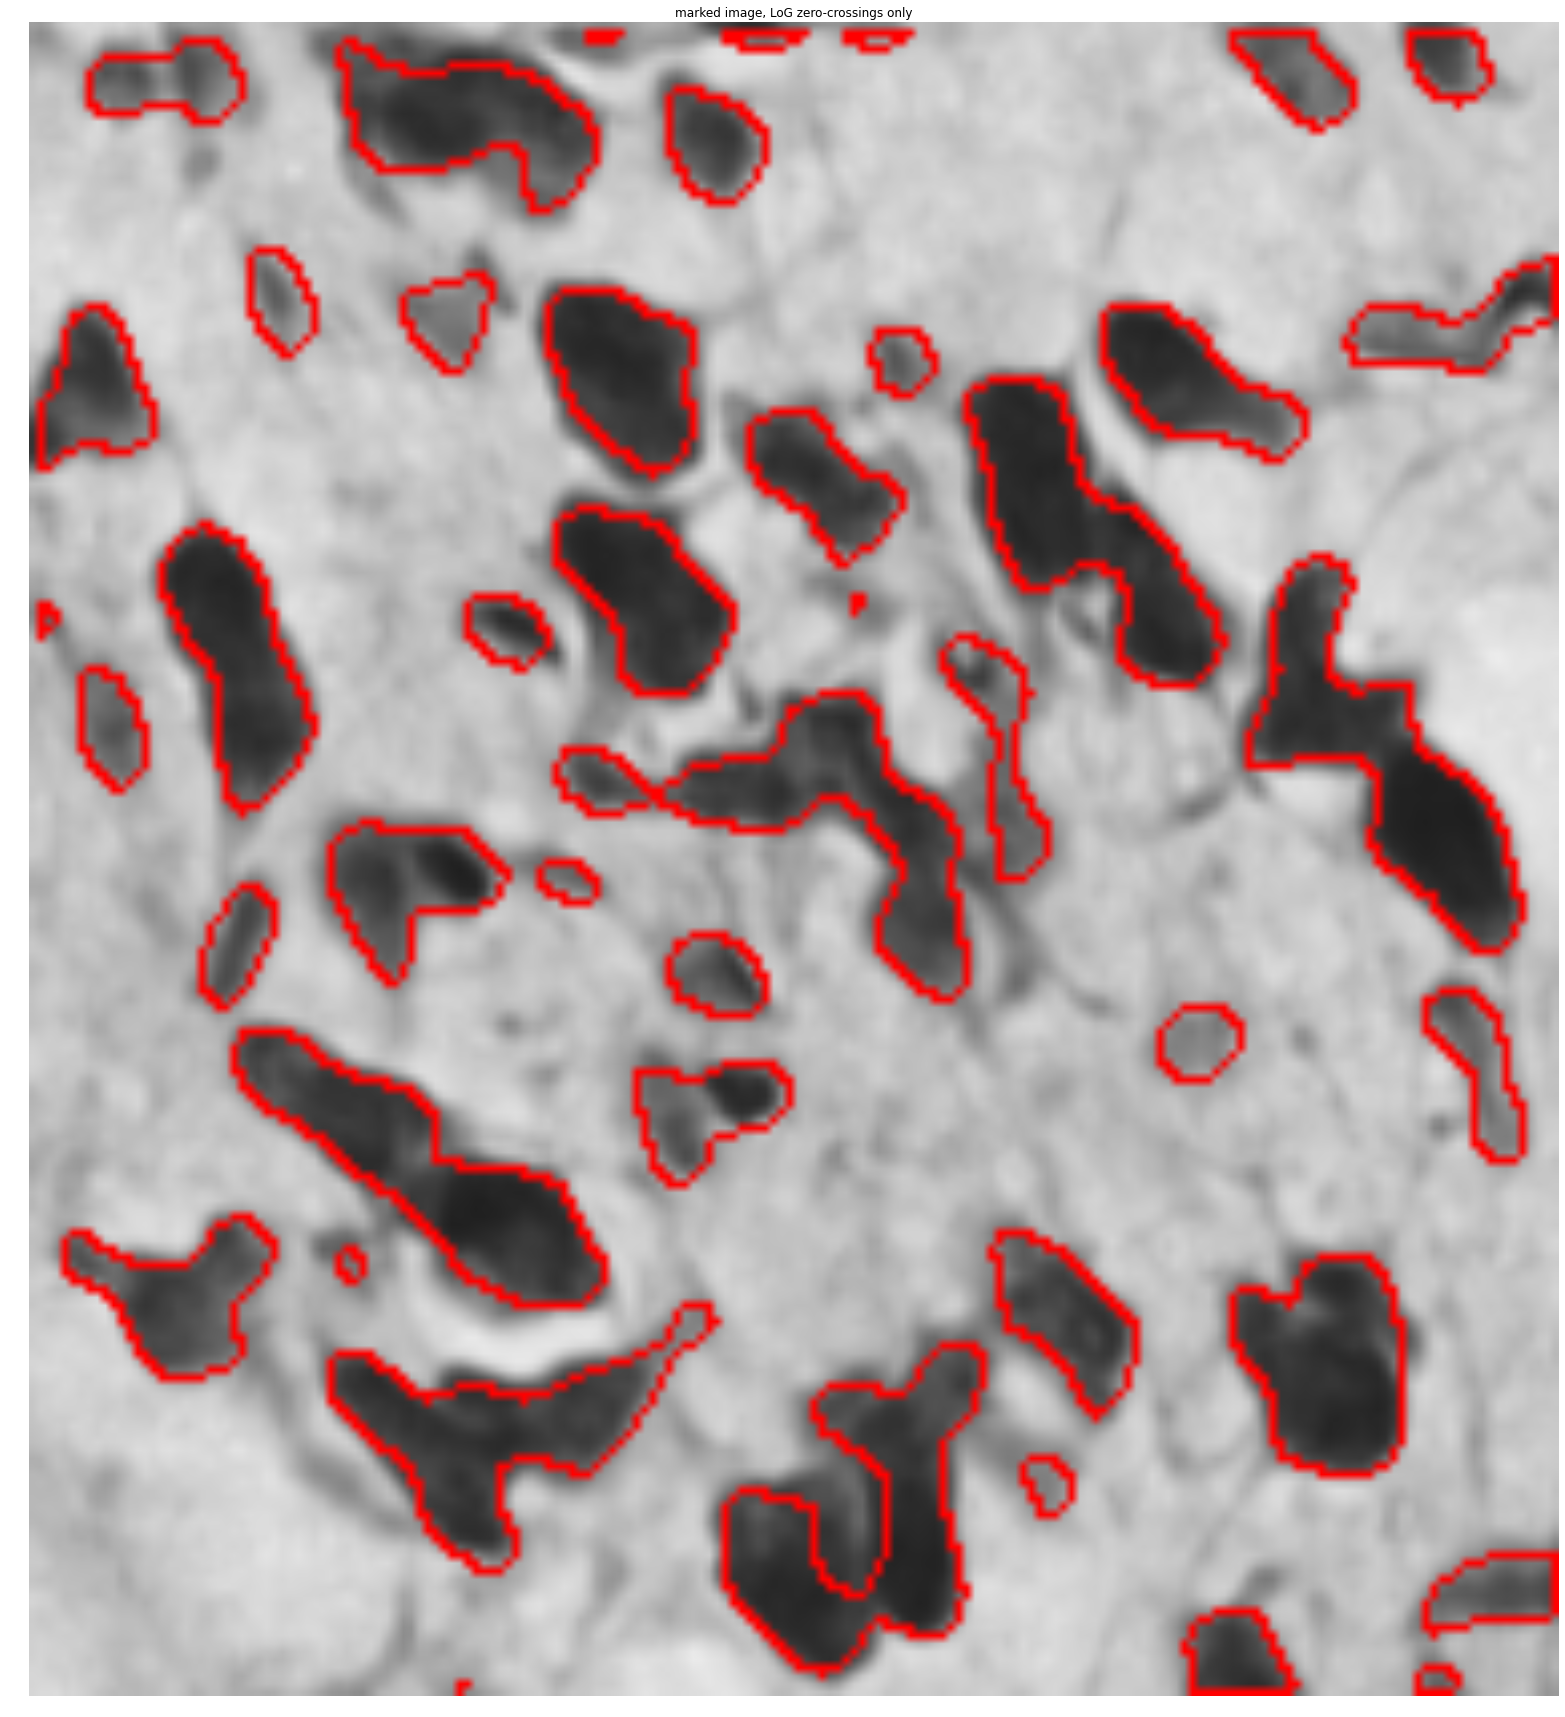

In [102]:
output = np.zeros_like(im, dtype=np.bool)
output[zero_crossings3] = True

marked_im = gray2rgb(im)
marked_im[output] = (255,0,0)

plt.figure(figsize=(30,30));
plt.imshow(marked_im, cmap=plt.cm.gray);
plt.axis('off');
plt.title('marked image, LoG zero-crossings only');


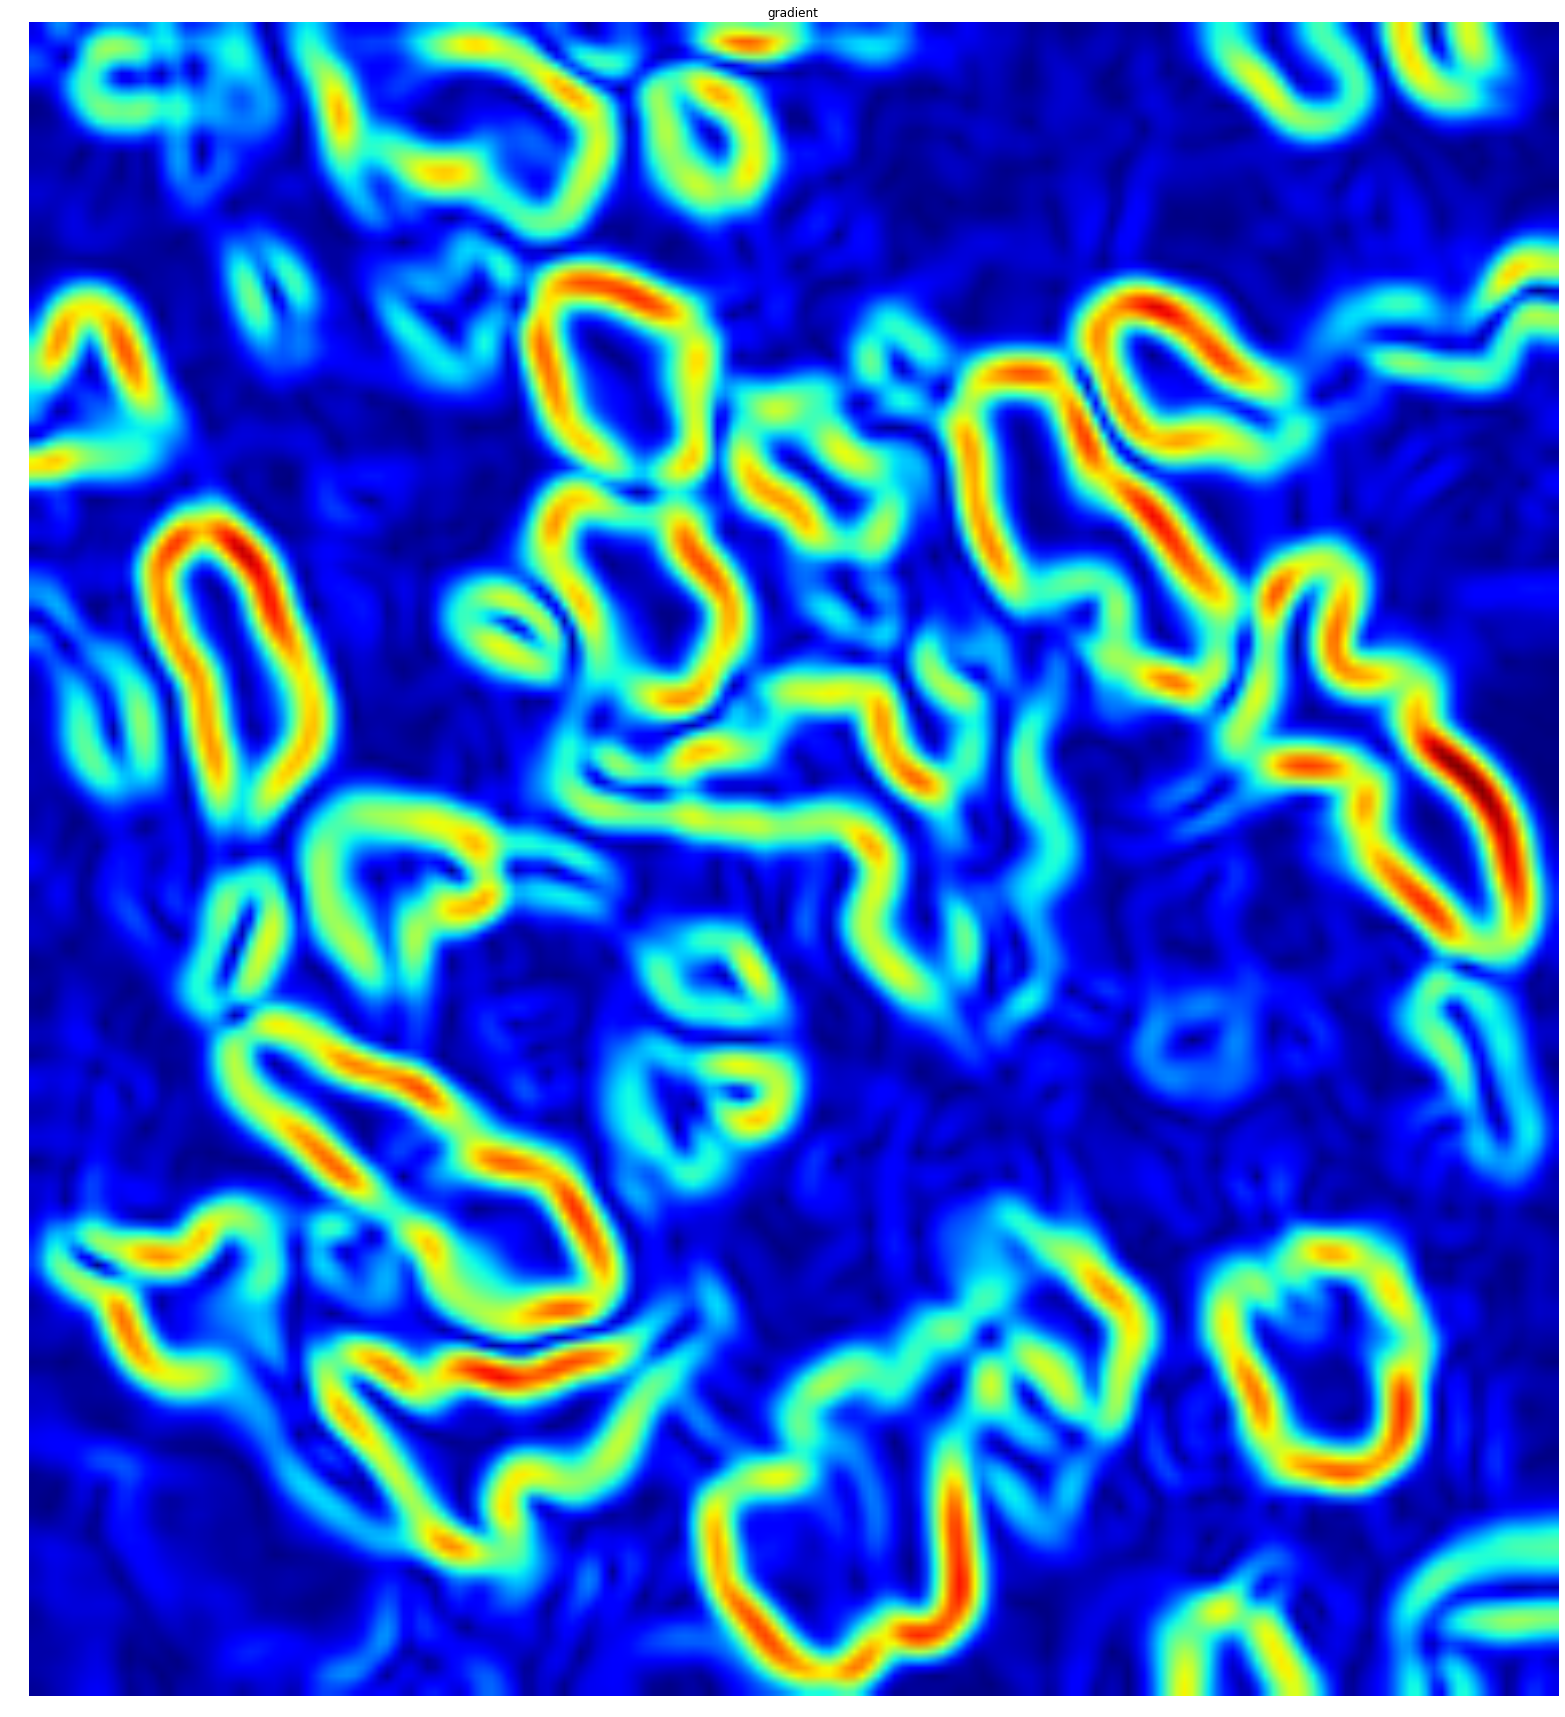

In [103]:
Gy, Gx = np.gradient(nd.gaussian_filter(im.astype(np.float), 2))
# Gy, Gx = np.gradient(im.astype(np.float))
G = np.sqrt(Gx**2+Gy**2)

plt.figure(figsize=(30, 30));
plt.imshow(G);
plt.axis('off');
plt.title('gradient');
# plt.colorbar();

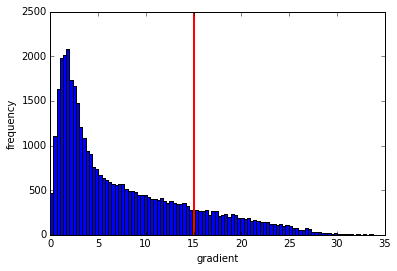

In [104]:
G_thresh = 15

plt.hist(G.flat, bins=100);
plt.gca().axvline(x=G_thresh, c='r', linewidth=2);
plt.xlabel('gradient');
plt.ylabel('frequency');

In [13]:
# for LoG_thres in np.arange(0,2,.1):
# # LoG_thres = np.absolute(-LoG).mean()

# # LoG_thres = -.01
# # LoG_thres = 0.

#     s3 = np.sign(LoG - LoG_thres)
#     s3[s3==0] = -1     # replace zeros with -1

#     diff_x = np.r_[np.zeros((1,im.shape[1]), np.bool), (np.diff(s3, axis=0) != 0)]
#     diff_y = np.c_[np.zeros((im.shape[0], 1), np.bool), (np.diff(s3, axis=1) != 0)]

#     zero_crossings3 = np.where(diff_x | diff_y)

#     output = np.zeros_like(im, dtype=np.bool)
#     output[zero_crossings3] = True

#     marked_im = gray2rgb(im)
#     marked_im[output] = (255,0,0)

#     plt.figure();
#     plt.imshow(marked_im, cmap=plt.cm.gray);
#     plt.axis('off');
#     plt.title('marked image, LoG zero-crossings only, %f' % LoG_thres);

In [105]:
from scipy.ndimage import label
from skimage.morphology import square
from skimage.measure import regionprops

In [106]:
labeled, n_rings = label(output, square(3))

In [107]:
props = regionprops(labeled, G)

In [108]:
cell_mean_gradient = np.array([p.mean_intensity for p in props])

In [109]:
valid = np.where(cell_mean_gradient > 10)[0]

In [110]:
cell_contour_coords = np.array([p.coords for i, p in enumerate(props) if i in valid])

In [111]:
cell_bbox = np.array([p.bbox for i, p in enumerate(props) if i in valid])

In [112]:
cell_bbox_masks = []
for i, box in enumerate(cell_bbox):
    
    ymin, xmin, ymax, xmax = cell_bbox[i]
    cell_im = im[ymin:ymax+1, xmin:xmax+1].copy()
    h, w = cell_im.shape

    bbox = np.zeros((h, w))
    bbox[cell_contour_coords[i][:,0]-ymin, cell_contour_coords[i][:,1]-xmin] = 1    
    cell_bbox_mask = nd.binary_fill_holes(bbox)
    cell_bbox_masks.append(cell_bbox_mask)
    

In [113]:
cell_sizes = np.array([np.count_nonzero(m) for m in cell_bbox_masks])
size_hist, sizes = np.histogram(cell_sizes, bins=100)

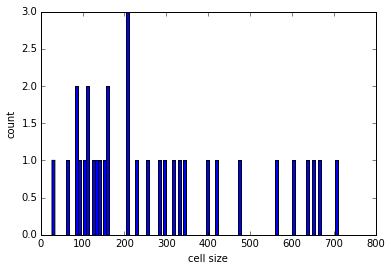

In [114]:
plt.hist(cell_sizes, bins=100);
plt.xlabel('cell size');
plt.ylabel('count');

In [120]:
large_ones = np.where(cell_sizes > 200)[0]

In [121]:
cell_contour_coords_large = cell_contour_coords[large_ones]
cell_bbox_masks_large = [cell_bbox_masks[i] for i in large_ones]
cell_bbox_large = cell_bbox[large_ones]
cell_sizes_large = cell_sizes[large_ones]

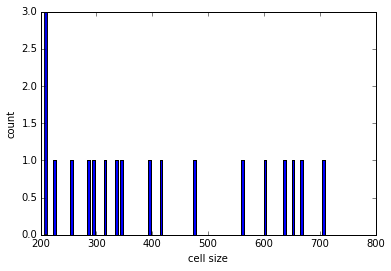

In [122]:
plt.hist(cell_sizes_large, bins=100);
plt.xlabel('cell size');
plt.ylabel('count');

In [123]:
n_large_cells = len(cell_bbox_large)
print n_large_cells

19


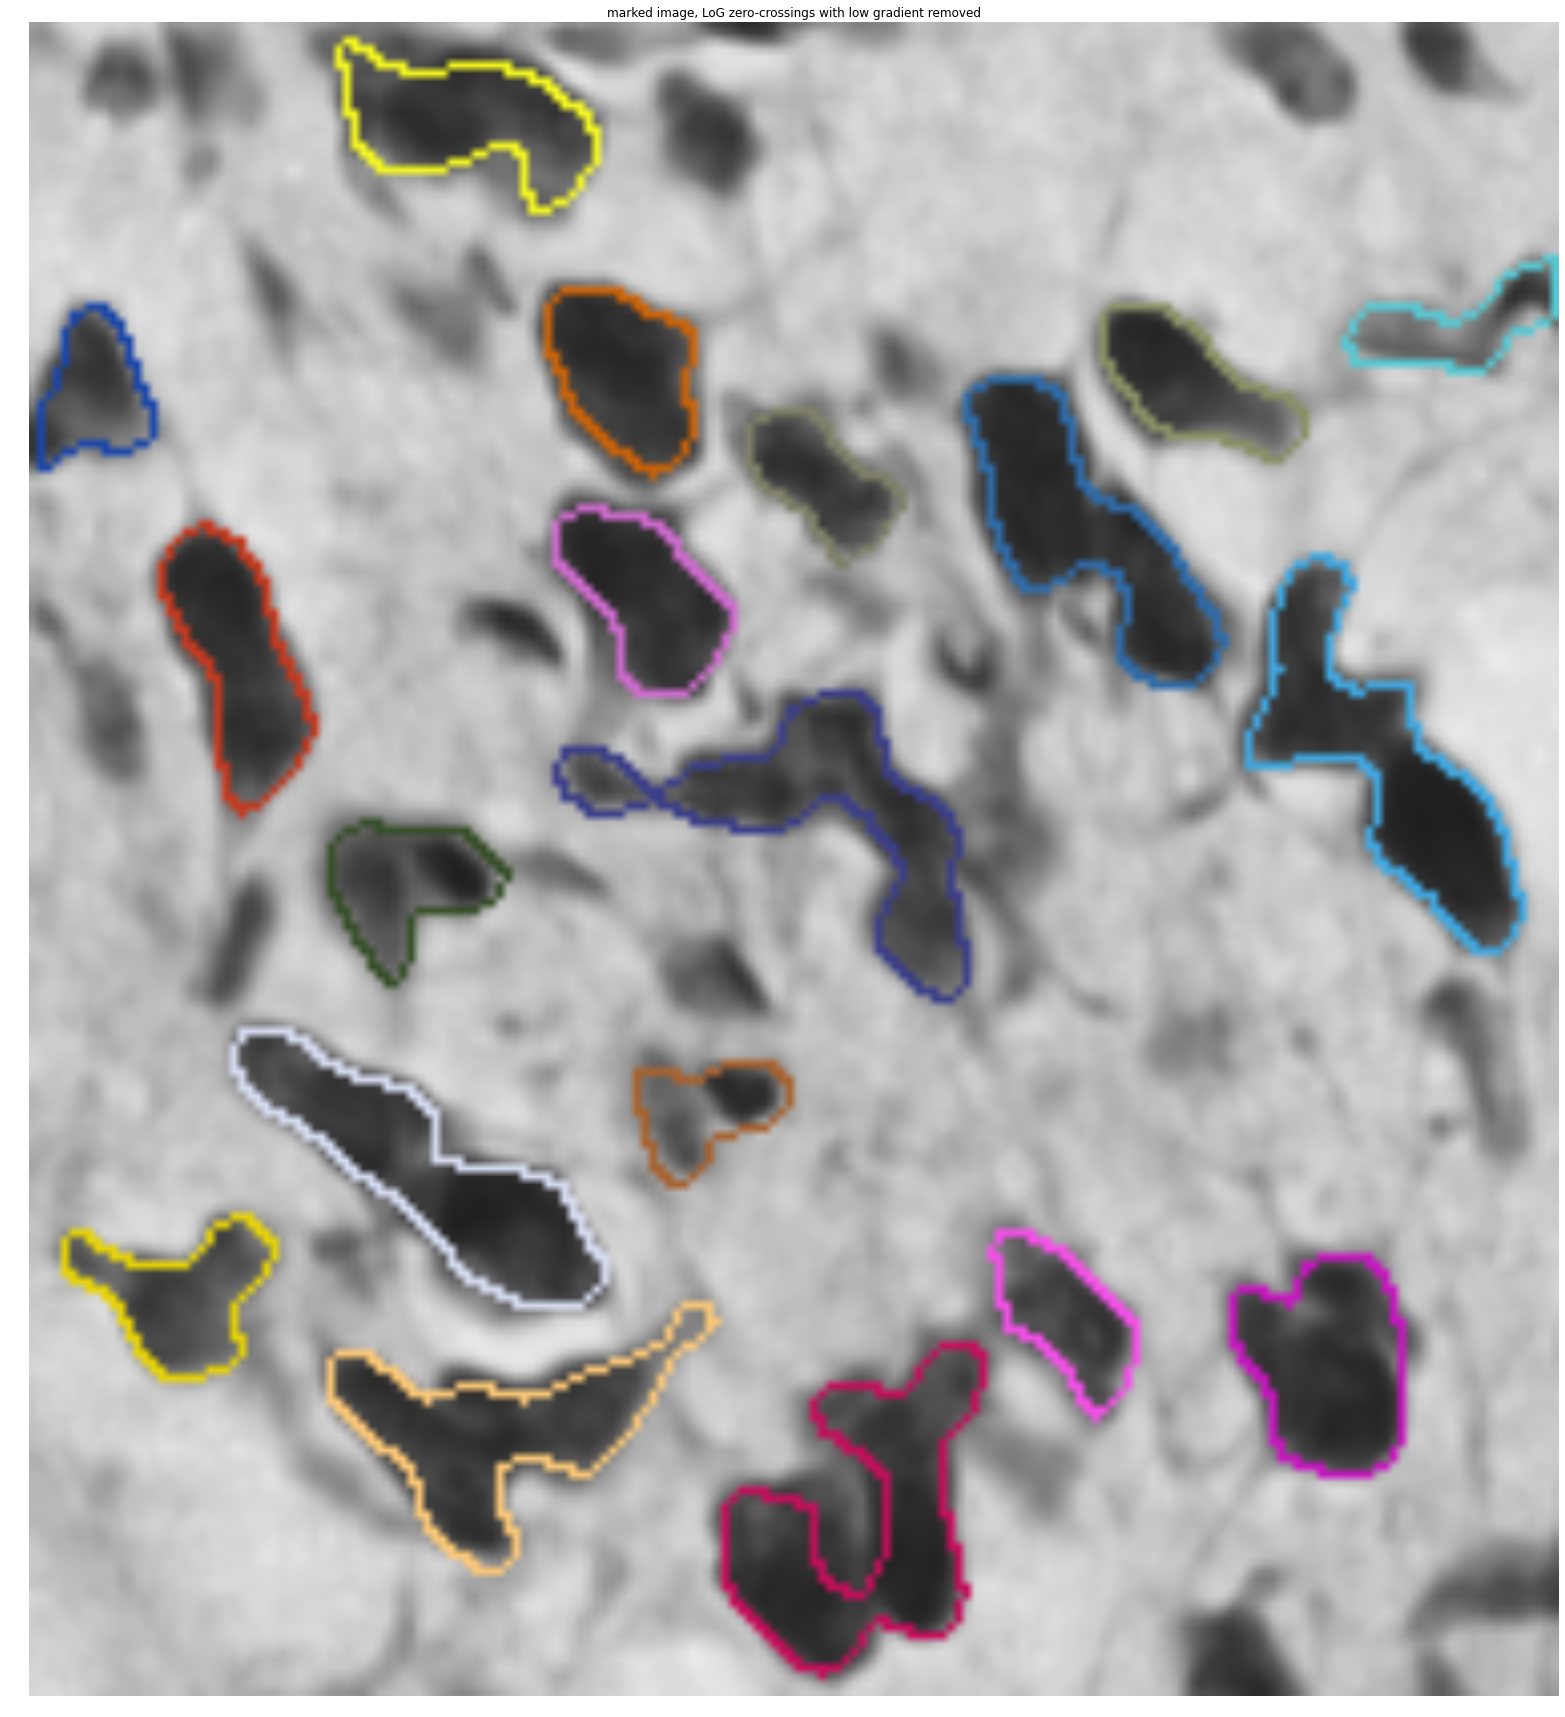

In [124]:
marked_im2 = gray2rgb(im)

for coords in cell_contour_coords_large:
    marked_im2[coords[:,0], coords[:,1]] = (np.random.random((3,)) * 255).astype(np.int)

plt.figure(figsize=(30, 30));
plt.imshow(marked_im2);
plt.axis('off');
plt.title('marked image, LoG zero-crossings with low gradient removed');

In [133]:
cell_bbox_shapes_large = [m.shape for m in cell_bbox_masks_large]
largest_bbox_shape = np.max(cell_bbox_shapes_large, axis=0)

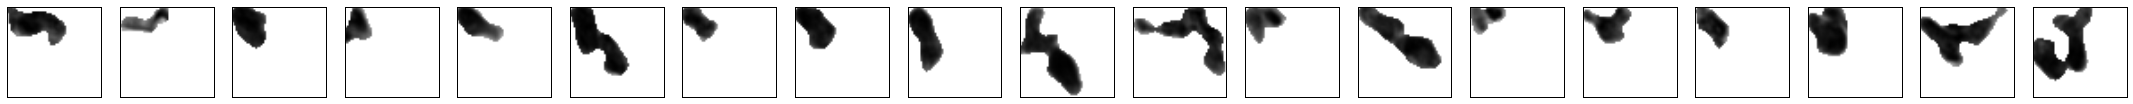

In [145]:
# the sizes of cells are artifically normalized.

fig, axes = plt.subplots(n_large_cells/20+1, 20, figsize=(40,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= n_large_cells:
        ax.set_visible(False)
    else:
        
        ymin, xmin, ymax, xmax = cell_bbox_large[i]
        cell_im = im[ymin:ymax+1, xmin:xmax+1].copy()

        h, w = cell_im.shape

        cell_im[~cell_bbox_masks_large[i]] = 255
    #     ax.imshow(cell_im, cmap=plt.cm.gray);

        canvas = 255 * np.ones(largest_bbox_shape)
        canvas[:h, :w] = cell_im

        ax.imshow(canvas, cmap=plt.cm.gray);

        ax.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            left='off',
            right='off',
            labelbottom='off',
            labelleft='off') #

    #     ax.axis('off');

In [ ]:
# Use a higher LoG_thres

LoG_thres = 1.

s3 = np.sign(LoG - LoG_thres)
s3[0,:] = 0
s3[-1,:] = 0
s3[:,0] = 0
s3[:,-1] = 0

s3[s3==0] = -1     # replace zeros with -1

diff_x = np.r_[np.zeros((1,im.shape[1]), np.bool), (np.diff(s3, axis=0) != 0)]
diff_y = np.c_[np.zeros((im.shape[0], 1), np.bool), (np.diff(s3, axis=1) != 0)]
           
zero_crossings3 = np.where(diff_x | diff_y)

output = np.zeros_like(im, dtype=np.bool)
output[zero_crossings3] = True

plt.figure(figsize=(10,10));

labeled, n_rings = label(output, square(3))
props = regionprops(labeled, G)
cell_mean_gradient = np.array([p.mean_intensity for p in props])

valid = np.where(cell_mean_gradient > 10)[0]

cell_contour_coords = np.array([p.coords for i, p in enumerate(props) if i in valid])
cell_bbox = np.array([p.bbox for i, p in enumerate(props) if i in valid])

cell_bbox_masks = []
for i, box in enumerate(cell_bbox):
    
    ymin, xmin, ymax, xmax = cell_bbox[i]
    cell_im = im[ymin:ymax+1, xmin:xmax+1].copy()
    h, w = cell_im.shape

    bbox = np.zeros((h, w))
    bbox[cell_contour_coords[i][:,0]-ymin, cell_contour_coords[i][:,1]-xmin] = 1    
    cell_bbox_mask = nd.binary_fill_holes(bbox)
    cell_bbox_masks.append(cell_bbox_mask)
    
cell_sizes = np.array([np.count_nonzero(m) for m in cell_bbox_masks])
size_hist, sizes = np.histogram(cell_sizes, bins=100)

cell_size_thresh = 200

large_ones = np.where(cell_sizes > cell_size_thresh)[0]

cell_contour_coords_large = cell_contour_coords[large_ones]
cell_bbox_masks_large = [cell_bbox_masks[i] for i in large_ones]
cell_bbox_large = cell_bbox[large_ones]
cell_sizes_large = cell_sizes[large_ones]

n_large_cells = len(cell_bbox_large)
print n_large_cells

marked_im2 = gray2rgb(im)

for coords in cell_contour_coords_large:
    marked_im2[coords[:,0], coords[:,1]] = (np.random.random((3,)) * 255).astype(np.int)

plt.figure(figsize=(10, 10));
plt.imshow(marked_im2);
plt.axis('off');
plt.title('marked image, LoG zero-crossings with low gradient and small detections removed');